In [33]:
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [55]:
from pathlib import Path

WORKSPACE_DIR = str(Path().resolve())
IMAGE_PATH = str(Path(WORKSPACE_DIR, "data", "apple.png"))
SC_IMAGE_PATH = str(Path(WORKSPACE_DIR, "data", "screenshot_profiling.png"))
MODEL_PATH = str(Path(WORKSPACE_DIR, "model", "u2net.onnx"))

print(Path(IMAGE_PATH).exists() and Path(MODEL_PATH).exists())

True


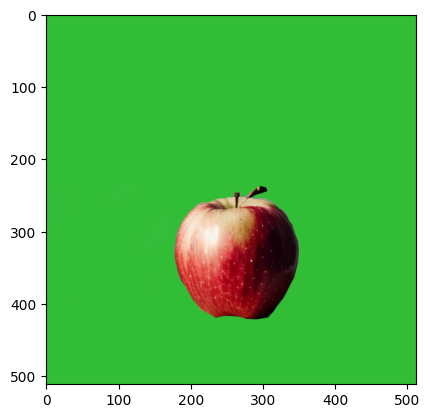

In [11]:
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# Load Image
image = PILImage.open(IMAGE_PATH)

plt.imshow(image)

In [12]:
import onnxruntime as ort

providers = [provider for provider in ort.get_available_providers() if provider != "TensorrtExecutionProvider"]
print(providers)

['CUDAExecutionProvider', 'CPUExecutionProvider']


In [9]:
session = ort.InferenceSession(MODEL_PATH, providers=providers)c

In [24]:
import numpy as np
from PIL import Image as PILImage
from typing import Tuple, Dict


# https://github.com/danielgatis/rembg/blob/main/rembg/sessions/base.py
def normalize(
    image: PILImage,
    session: ort.InferenceSession,
    mean: Tuple[float, float, float] = (0.485, 0.456, 0.406),
    std: Tuple[float, float, float] = (0.229, 0.224, 0.225),
    size: Tuple[int, int] = (320, 320)
) -> Dict[str, np.ndarray]:
    im = image.convert("RGB").resize(size, PILImage.LANCZOS)

    im_ary = np.array(im)
    im_ary = im_ary / np.max(im_ary)

    image_f = np.zeros((im_ary.shape[0], im_ary.shape[1], 3))
    image_f[:, :, 0] = (im_ary[:, :, 0] - mean[0]) / std[0]
    image_f[:, :, 1] = (im_ary[:, :, 1] - mean[1]) / std[1]
    image_f[:, :, 2] = (im_ary[:, :, 2] - mean[2]) / std[2]
    return {session.get_inputs()[0].name: np.expand_dims(image_f.transpose((2, 0, 1)), 0).astype(np.float32)}


In [50]:
from PIL import ImageFilter as PILImageFilter


# https://github.com/danielgatis/rembg/blob/main/rembg/sessions/u2net.py
# https://github.com/danielgatis/rembg/blob/main/rembg/sessions/base.py
def get_foreground_mask_u2net(image: PILImage, session: ort.InferenceSession) -> np.ndarray:
    pred = session.run(None, normalize(image, session))[0][:, 0, :, :]

    pred_max = np.max(pred)
    pred_min = np.min(pred)

    pred = (pred - pred_min) / (pred_max - pred_min)
    pred = np.squeeze(pred)

    mask = PILImage.fromarray((pred * 255).astype("uint8"), mode="L")
    mask = mask.resize(image.size, PILImage.LANCZOS)
    mask = mask.filter(PILImageFilter.GaussianBlur(radius=2))
    mask = mask.point(lambda x: 0 if x < 127 else 255)
    return np.asarray(mask, dtype=np.uint8)


In [51]:
%scrun get_foreground_mask_u2net(image, session)

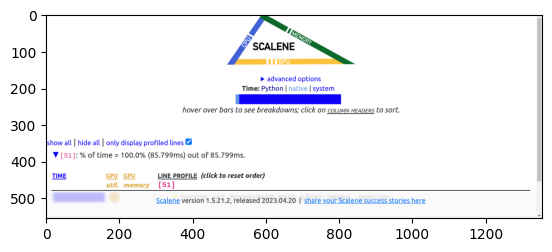

In [56]:
# For github browser
sc_image = PILImage.open(SC_IMAGE_PATH)
plt.imshow(sc_image)

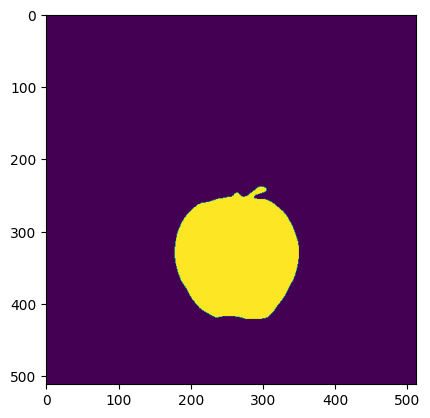

In [53]:
mask_fg = get_foreground_mask_u2net(image, session)

plt.imshow(mask_fg)

In [54]:
print(type(mask_fg), mask_fg.shape, mask_fg.dtype)
print(f"mask foreground:\n {mask_fg}")

<class 'numpy.ndarray'> (512, 512) uint8
mask foreground:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
